In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

In [ ]:
from simulation import run_simulation
from vowpalwabbit import pyvw
import numpy as np
from policies import *
from environment import Servers

In [ ]:
%%capture
from tqdm.tqdm_notebook import tqdm

In [ ]:
# Initialize basic variables
num_requests = 5#int(input("num_requests: "))
num_servers = 3#int(input("num_servers: "))

# Initialize policies
behavior_policy = ('UniRan', UniRan(num_servers))
target_policy1 = ('LeastLoad_0.3', LeastLoad(num_servers, epsilon=0.3))
target_policy2 = ('LeastLoad_0', LeastLoad(num_servers, epsilon=0))
target_policy3 = ('EpsilonGreedy', EpsilonGreedy(num_servers, epsilon=0.3))
target_policy4 = ('UCB1', UCB1(num_servers))

# behavior_policy = ('EpsilonGreedy', EpsilonGreedy(num_servers, epsilon=0.3))
# target_policy1 = ('LeastLoad_0.3', LeastLoad(num_servers, epsilon=0.3))
# target_policy2 = ('LeastLoad_0', LeastLoad(num_servers, epsilon=0))
# target_policy3 = ('UniRan', UniRan(num_servers))
# target_policy4 = ('UCB1', UCB1(num_servers))


target_policies = [target_policy1, target_policy2, target_policy3, target_policy4]
num_target_policies = len(target_policies)

policies = [target_policy1, target_policy2, target_policy3, target_policy4, behavior_policy]
num_policies = 1 + num_target_policies

target_policy_names = [policy[0] for policy in policies if policy != policies[-1]]

# Initialize environment (servers)
servers = Servers(num_policies=num_policies, num_servers=num_servers)


In [ ]:
import pickle

In [ ]:
trace_lst = []
latency_lst = []
for _ in tqdm(range(5*10**5)):
    total_latency_for_each_policy, trace = \
                run_simulation(policies=policies, num_requests=num_requests, servers=servers)
    trace_lst.append(trace)
    latency_lst.append(total_latency_for_each_policy)
#with open('trace1.p', 'wb') as fp:
    #pickle.dump(trace_lst, fp)           
#with open('latency1.p', 'wb') as fp:
    #pickle.dump(latency_lst, fp)  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
trace=np.array(trace_lst)
latency=np.array(latency_lst)

In [134]:
class ActionValueModel:
    r"""
    ActionValueModel is a class that represents
    an action value model (Q_\pi) for a fixed (stationary) policy \pi
    in reinforcement learning (RL) framework.

    You can have any action value model (DM), but it should subclass
    this abstract class.
    """

    def __init__(self, horizon, num_actions, policy):
        """
        Params:
            horizon: horizon of the environment (We use a fixed horizon here)
            num_actions: number of actions (we are not using continus actions; action index starts from 0)
            policy: the policy that we want to learn the Q value of
        """

        self.horizon = horizon
        self.num_actions = num_actions
        self.policy = policy

    def get_Q(self, index, state, action):
        """
        Return Q_pi(state, action) at the given index

        Params:
            index: the step of Q_pi we want to get (thus, index ranges from 0 to self.horizon - 1)
            state: the state in Q_pi(state, action)
            action: the action in Q_pi(state, action)
        """

        raise NotImplementedError

    def get_V(self, index, sample, new_p):
        """
        Return V(state)

        Params:
            index: the step of Q_pi we want to get (thus, index ranges from 0 to self.horizon - 1)
            sample: the sample of the given index from a trace.
                    sample is a list (or tuple) of [state, action, reward, behavior_probabilities]
        """

        if index > self.horizon - 1:
            return 0

        state = sample[0]
        V_estimate = 0
        #for action_index, new_prob in enumerate(self.policy.choose_action(context=state[0],
                                                                          #return_prob=True,
                                                                          #behavior_policy=False,
                                                                          #chosen_action=sample[1])):
            #V_estimate += new_prob * self.get_Q(index, state, action_index)
        for i, p in enumerate(new_p):
            V_estimate += p*self.get_Q(index, state, i)

        return V_estimate

    def update_Q(self, index, sample, next_sample):
        """
        Update Q_\pi at the given index, with the given next state.

        Params:
            index: the step of Q_pi we want to update (thus, index ranges from 0 to self.horizon - 1)
            sample: the sample of the given index from a trace.
                    sample is a list (or tuple) of [state, action, reward, behavior_probabilities]
            next_sample: the next sample observed after the given sample in the trace.
        """

        raise NotImplementedError

In [149]:
class VWActionValueModel(ActionValueModel):
    r"""
    An ActionValueModel using VowpalWabbit (VW)

    the given VW format can be changed as you want.
    Think about if the given VW format is correct! 
    """

    def __init__(self, horizon, num_actions, policy, default_model="--power_t 0.0 -q la --quiet"):
        """
        Initialize variables to store basic information of MDP
        and every Q model needed for each step.

        Params:
            default_model: a default VW model to learn Q. You can try different settings to get the best model.
        """
        super().__init__(horizon, num_actions, policy)

        # We assume that each step is indexed from 0 to H (horizon) - 1
        self.models = [pyvw.vw(default_model) for _ in range(self.horizon)]

    def vw_format(self, state_server_load, action, reward=None):
        """
        Convert a given sample to a VW example.
        The current format of state only includes server load. Change it if needed.

        Params:
            state_server_load: the state in the given sample.
            action: the action chosen by the logging policy in the given sample
            reward: the reward revealed by the chosen action.
                    If the function vw_format is used to predict Q value,
                    reward should be None.
        """

        vw_example = ""

        if reward is not None:
            vw_example += f"{reward} "

        # Add server load (l stands for load)
        vw_example += "|l"

        for server_index in range(self.num_actions):
            vw_example += f" load{server_index}:{state_server_load[server_index]}"

        # Add the chosen action
        vw_example += f" |a server{action}"

        return vw_example

    def get_Q(self, index, state, action):
        """
        Return Q_pi(state, action) at the given index

        Params:
            index: the step of Q_pi we want to get (thus, index ranges from 0 to self.horizon - 1)
            state: the state in Q_pi(state, action).
            action: the action in Q_pi(state, action)
        """
        if index > self.horizon - 1:
            return 0

        model = self.models[index]
        sample_in_vw_format = self.vw_format(state_server_load=state[0],
                                             action=action)

        return model.predict(sample_in_vw_format)

    def update_Q(self, index, sample, next_sample=None, next_p=None):
        """
        Update Q_\pi at the given index, with the given next state.

        Params:
            index: the step of Q_pi we want to update (thus, index ranges from 0 to self.horizon - 1)
            sample: the sample of the given index from a trace.
                    sample is a list (or tuple) of [state, action, reward, behavior_probabilities]
            next_sample: the next sample observed after the given sample in the trace.
        """
        next_state_V_estimate = self.get_V(index + 1, next_sample, next_p)
        sample_in_vw_format = self.vw_format(state_server_load=sample[0][0],
                                             action=sample[1],
                                             reward=sample[2] + next_state_V_estimate)

        model = self.models[index]
        model.learn(sample_in_vw_format)

In [172]:
class DR(VWActionValueModel):
    def __init__(self, new_policy):
        self.policy = new_policy
        self.horizon = num_requests
        super().__init__(self.horizon, num_servers, new_policy)
        self.estimates = list()

    def get_estimate(self, traj):
        """
        Append the DR estimate of a single sample to self.estimates.
        You should implement this function
        """
        rho_t=1
        rho_t_1=1
        estimate=0
        self.policy.reset()
        for i, sample in enumerate(traj):
            state, action, r, old_p = sample
            server_load, lst_rewards = state
            for a_, r_ in lst_rewards:
                self.policy.update(a_, r_)
            new_p = self.policy.choose_action(context=server_load,
                                         return_prob=True,
                                          behavior_policy=False,
                                          chosen_action=action)
            rho_t *= new_p[action]/old_p[action]
            estimate += rho_t*r - (rho_t*self.get_Q(i, state, action)
                                  -rho_t_1*self.get_V(i, sample, new_p))
            rho_t_1 = rho_t
        
        self.estimates.append(estimate)

        self.policy.reset()
        # Update policy at t=0
        new_p = self.policy.choose_action(context=traj[0][0][0],
                                         return_prob=True,
                                          behavior_policy=True,
                                          chosen_action=traj[0][1])
        for a_, r_ in traj[0][0][1]:
            self.policy.update(a_, r_)

        for i in range(self.horizon):
            if i == self.horizon-1:
                self.update_Q(i, traj[i])
            else:
              # Policy has to be updated at t=i+1 before updating Q (to get next V)
                for a_, r_ in traj[i+1][0][1]:
                    self.policy.update(a_, r_)
                next_p = self.policy.choose_action(context=traj[i+1][0][0],
                                         return_prob=True,
                                          behavior_policy=False,
                                          chosen_action=traj[i+1][1])
                self.update_Q(i, traj[i], traj[i+1], next_p)

    def evaluation(self, num_samples):
        """
        Get the mean of num_samples number of DR estimates
        """
        return np.mean(self.estimates[:num_samples])

    def bootstrap(self, num_samples, bootstrap_num, true_performance):
        bootstrap_estimates = [self.evaluation(num_samples)]
        
        new_list = self.estimates[:num_samples]

        for _ in range(1, bootstrap_num):
            bootstrap_list = np.random.choice(new_list, size=num_samples)
            bootstrap_estimates.append(np.mean(bootstrap_list))

        errors_list = [abs(true_performance - estimate) / -true_performance for estimate in bootstrap_estimates]

        return (np.mean(errors_list)), np.std(errors_list)
    


In [173]:
class IS():
    def __init__(self, new_policy):
        self.estimates = list()
        self.policy = new_policy
        self.horizon = num_requests
    
    def get_estimate(self, traj):
        rho_t=1
        estimate=0
        self.policy.reset()
        for i, sample in enumerate(traj):
            state, action, r, old_p = sample
            server_load, lst_rewards = state
            for a_, r_ in lst_rewards:
                self.policy.update(a_, r_)
            new_p = self.policy.choose_action(context=server_load,
                                         return_prob=True,
                                          behavior_policy=False,
                                          chosen_action=action)
            rho_t *= new_p[action]/old_p[action]
            estimate += rho_t*r
        
        self.estimates.append(estimate)

    def evaluation(self, num_samples):
        return np.mean(self.estimates[:num_samples])

    def bootstrap(self, num_samples, bootstrap_num, true_performance):
        bootstrap_estimates = [self.evaluation(num_samples)]
        
        new_list = self.estimates[:num_samples]

        for _ in range(1, bootstrap_num):
            bootstrap_list = np.random.choice(new_list, size=num_samples)
            bootstrap_estimates.append(np.mean(bootstrap_list))

        errors_list = [abs(true_performance - estimate) / -true_performance for estimate in bootstrap_estimates]

        return (np.mean(errors_list)), np.std(errors_list)
    

In [174]:
num_samples = trace.shape[0]
dr_estimator1 = DR(target_policy1[1])
dr_estimator2 = DR(target_policy2[1])
dr_estimator3 = DR(target_policy3[1])
dr_estimator4 = DR(target_policy4[1])
is_estimator1 = IS(target_policy1[1])
is_estimator2 = IS(target_policy2[1])
is_estimator3 = IS(target_policy3[1])
is_estimator4 = IS(target_policy4[1])

for sample_index in tqdm(range(10**5)):
    is_estimator1.get_estimate(trace[sample_index])
    is_estimator2.get_estimate(trace[sample_index])
    is_estimator3.get_estimate(trace[sample_index])
    is_estimator4.get_estimate(trace[sample_index])
    dr_estimator1.get_estimate(trace[sample_index])
    dr_estimator2.get_estimate(trace[sample_index])
    dr_estimator3.get_estimate(trace[sample_index])
    dr_estimator4.get_estimate(trace[sample_index])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [177]:
true_values = np.mean(latency, axis=0)

# List the error of each estimator
dr_estimators = [dr_estimator1, dr_estimator2, dr_estimator3, dr_estimator4]
is_estimators = [is_estimator1, is_estimator2, is_estimator3, is_estimator4]
bootstrap_num = 100

dr_means = [np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(5)]
is_means = [np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(5)]
dr_stds = [np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(5)]
is_stds = [np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(5)]

for j in range(4):
    for i in range(1, 6):
        num_samples = int(10**i)
        mean, std = dr_estimators[j].bootstrap(num_samples, bootstrap_num, true_values[j])
        dr_means[j][i-1] = mean
        dr_stds[j][i-1] = std
        mean, std = is_estimators[j].bootstrap(num_samples, bootstrap_num, true_values[j])
        is_means[j][i-1] = mean
        is_stds[j][i-1] = std


In [178]:
for j in range(4):
    print('Policy ', j+1)
    print('IS')
    for i in range(5):
        print(f"(num_samples: {10**(i+1)}): (mean: {is_means[j][i]} / std: {is_stds[j][i]})")
    print('DR')
    for i in range(5):
        print(f"(num_samples: {10**(i+1)}): (mean: {dr_means[j][i]} / std: {dr_stds[j][i]})")

Policy  1
IS
(num_samples: 10): (mean: 0.5055141096664386 / std: 0.0841126087466967)
(num_samples: 100): (mean: 0.2185380779526419 / std: 0.09364272183659407)
(num_samples: 1000): (mean: 0.050763889190099484 / std: 0.034379548298934345)
(num_samples: 10000): (mean: 0.013034028146745584 / std: 0.00985369832205204)
(num_samples: 100000): (mean: 0.008867909271779035 / std: 0.0045499357965436025)
DR
(num_samples: 10): (mean: 0.3591546656600733 / std: 0.07712897063546471)
(num_samples: 100): (mean: 0.1139926338911985 / std: 0.05927137949328423)
(num_samples: 1000): (mean: 0.018054797642611076 / std: 0.01432336705550977)
(num_samples: 10000): (mean: 0.016417535143054277 / std: 0.008092848269088213)
(num_samples: 100000): (mean: 0.0017646964952084895 / std: 0.0014651104393120441)
Policy  2
IS
(num_samples: 10): (mean: 0.82422996587021 / std: 0.08638202220930342)
(num_samples: 100): (mean: 0.4220114616343803 / std: 0.17077649827082694)
(num_samples: 1000): (mean: 0.23736604679590986 / std: 0.0

In [179]:
import matplotlib.pyplot as plt

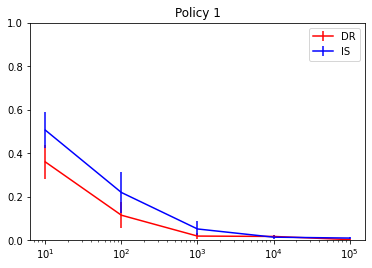

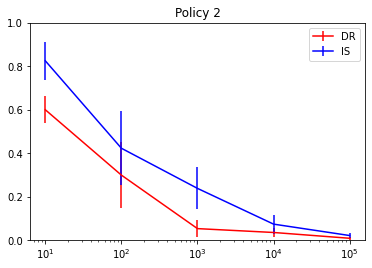

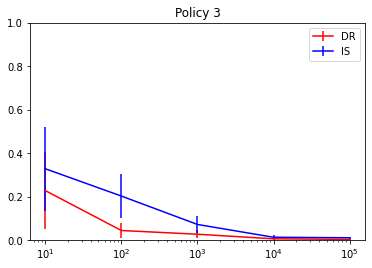

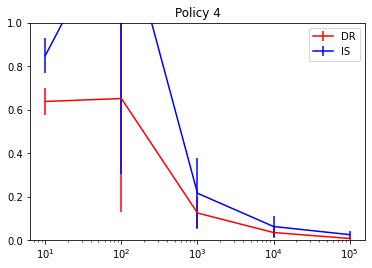

In [181]:
x = (np.array([10]*5)**range(1, 6))
for i in range(4):
    plt.errorbar(x, dr_means[i], yerr=dr_stds[i], color='r')
    plt.errorbar(x, is_means[i], yerr=is_stds[i], color='b')
    plt.title('Policy ' + str(i+1))
    plt.ylim((0,1))
    plt.xscale('log')
    plt.legend(['DR', 'IS'])
    plt.show()